# 🏦 Loan Analysis Training Pipeline

https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction 


This notebook:

 * selects features from feature groups to create a feature view
 * creates train/test data with the feature view
 * trains a model to predict loan approvals with the training set
 * evaluates the model on the test set
 * uploads the model along with evaluation data to Hopsworks

In [1]:
!pip install hopsworks

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

## 🔖 Hopsworks Feature Store

In [3]:
import hopsworks

proj = hopsworks.login()
fs = proj.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://35.187.37.222:443/p/119
Connected. Call `.close()` to terminate connection gracefully.


## Create the Feature View

In [4]:
fg_loans = fs.get_feature_group(name="loans", version=1)
fg_applicants = fs.get_feature_group(name="applicants", version=1)

query = fg_loans.select_except(["id", "issue_d"]).join(\
            fg_applicants.select_except(["earliest_cr_line", "earliest_cr_line_year", "id"]))

In [5]:
fv_version=1
try:
    fv = fs.get_feature_view(name="loans_approvals", version=fv_version)
except:
    fv = fs.create_feature_view(name="loans_approvals", 
                       version=fv_version,
                        description="Loan applicant data",
                        labels=["loan_status"],
                        query=query
                       )

Feature view created successfully, explore it at 
https://35.187.37.222:443/p/119/fs/67/fv/loans_approvals/version/1


In [6]:
start_time = time.time()

X_train, X_test, y_train, y_test = fv.train_test_split(test_size=0.2)

print("Get Random Split Training Data in %s seconds ---" % (time.time() - start_time))

Get Random Split Training Data in 7.849807977676392 seconds ---


In [7]:
X_test

,loan_amnt,term,int_rate,installment,sub_grade,purpose,zip_code,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
1,15000.00,36 months,13.35,507.95,C2,credit_card,0,RENT,52000.00,Verified,11.68,13.00,0,18391.00,60.70,21.00,w,INDIVIDUAL,0.00,0.00
9,11350.00,36 months,16.55,402.13,D2,debt_consolidation,48052,RENT,56300.00,Source Verified,29.27,6.00,0,21016.00,88.70,22.00,f,INDIVIDUAL,3.00,0.00
16,20000.00,60 months,9.99,424.85,B3,debt_consolidation,70466,MORTGAGE,94000.00,Not Verified,13.85,11.00,0,14642.00,28.50,25.00,w,INDIVIDUAL,3.00,0.00
29,18500.00,60 months,10.64,398.93,B2,debt_consolidation,48052,MORTGAGE,85000.00,Verified,8.64,7.00,0,9935.00,52.30,26.00,f,INDIVIDUAL,3.00,0.00
31,10000.00,36 months,13.05,337.19,B5,credit_card,0,MORTGAGE,52000.00,Not Verified,20.56,5.00,0,14408.00,92.40,22.00,f,INDIVIDUAL,4.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395205,3500.00,36 months,6.24,106.86,A2,home_improvement,22690,MORTGAGE,122000.00,Not Verified,9.28,9.00,0,3313.00,15.90,20.00,w,INDIVIDUAL,3.00,0.00
395208,32400.00,36 months,10.64,1055.22,B2,debt_consolidation,0,OWN,78000.00,Verified,22.44,7.00,0,27624.00,74.10,24.00,f,INDIVIDUAL,2.00,0.00
395209,5000.00,36 months,12.49,167.25,B5,debt_consolidation,22690,RENT,40000.00,Not Verified,20.40,10.00,0,4881.00,39.70,18.00,f,INDIVIDUAL,0.00,0.00
395212,20000.00,36 months,12.99,673.79,C2,debt_consolidation,22690,RENT,80000.00,Verified,20.80,10.00,0,49384.00,75.10,25.00,f,INDIVIDUAL,3.00,0.00


In [8]:
y_train

,loan_status
0,Fully Paid
2,Fully Paid
3,Fully Paid
4,Charged Off
5,Fully Paid
...,...
395214,Charged Off
395215,Charged Off
395216,Charged Off
395217,Fully Paid


In [9]:
# Map features to transformation functions.
categorical_features = []
numeric_features = []
for col in X_train.columns:
    if X_train[col].dtype == object:
        categorical_features.append(col)
    else:
        numeric_features.append(col)

print(numeric_features)
print(categorical_features)

['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
['term', 'sub_grade', 'purpose', 'zip_code', 'home_ownership', 'verification_status', 'initial_list_status', 'application_type']


In [11]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)

# Here, we are passing the column names to the ColumnTransformer 
# in 'numeric_features' and 'categorical_features'
# This means in inference, we also have to pass the names of the columns - you can only do this with a
# Pandas DataFrame. So, that means in online inference, you have to create a Pandas DataFrame to make
# the feature vector. If that is too slow, you should use "ids" here, instead of names, then you can use
# a numpy array instead of a Pandas DataFrame in online inference
# https://stackoverflow.com/questions/71715754/valueerror-specifying-the-columns-using-strings-is-only-supported-for-pandas-da
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [12]:
y_train['loan_status'] = y_train.loan_status.map({'Fully Paid':1, 'Charged Off':0})
y_test['loan_status'] = y_test.loan_status.map({'Fully Paid':1, 'Charged Off':0})

In [13]:
y_train

,loan_status
0,1
2,1
3,1
4,0
5,1
...,...
395214,0
395215,0
395216,0
395217,1


# 🤖 Models Building

In [14]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [15]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

clf.fit(X_train, y_train['loan_status'].ravel())


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amnt', 'int_rate',
                                                   'installment', 'annual_inc',
                                                   'dti', 'open_acc', 'pub_rec',
                                                   'revol_bal', 'revol_util',
                                                   'total_acc', 'mort_acc',
                                                   'pub_rec_bankruptcies']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('selector',
                                                                   SelectPercentile(percentile=50,
                                                                                    score_func=<function chi2 at 0x7f8c61f44940>))]),
                                                  ['term', 'sub_grade',
                                                   'purpose', 'zip_code',
                                                   'home_ownership',
                                                   'verification_status',
                                                   'initial_list_status',
                                                   'application_type'])])),
                ('classifier', LogisticRegression())])

In [16]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 88.90%
_______________________________________________
CLASSIFICATION REPORT:
                 0         1  accuracy  macro avg  weighted avg
precision     0.95      0.88      0.89       0.92          0.90
recall        0.46      0.99      0.89       0.73          0.89
f1-score      0.62      0.94      0.89       0.78          0.87
support   62071.00 254104.00      0.89  316175.00     316175.00
_______________________________________________
Confusion Matrix: 
 [[ 28372  33699]
 [  1399 252705]]

Test Result:
Accuracy Score: 88.96%
_______________________________________________
CLASSIFICATION REPORT:
                 0        1  accuracy  macro avg  weighted avg
precision     0.95     0.88      0.89       0.92          0.90
recall        0.46     0.99      0.89       0.73          0.89
f1-score      0.62     0.94      0.89       0.78          0.87
support   15452.00 63592.00      0.89   79044.00      79044.00
______________________________________________

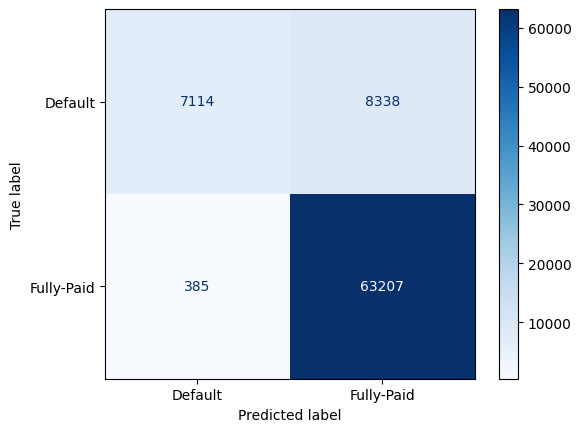

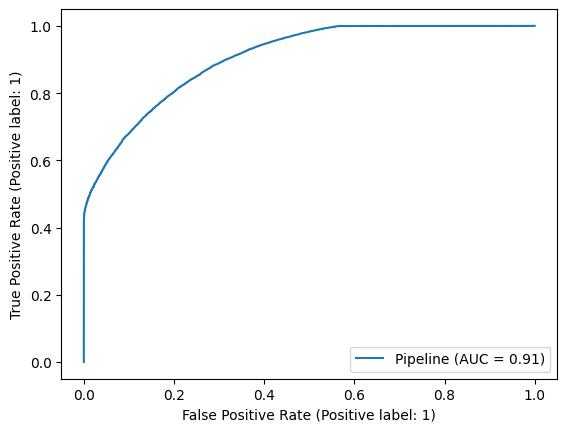

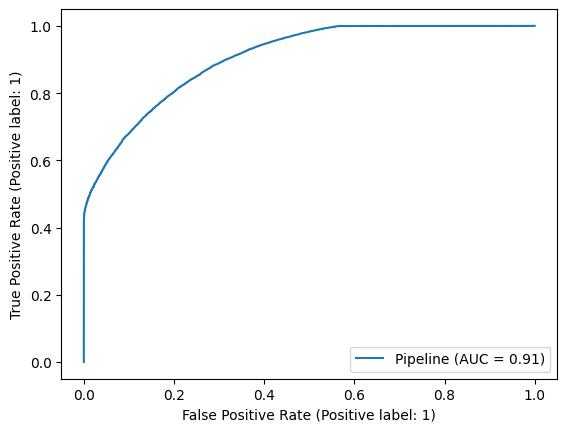

In [17]:
disp = ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

display = RocCurveDisplay.from_estimator(clf, X_test, y_test)
display.plot()

# ✔️ Register the Model with Model Registry

In [18]:
mr = proj.get_model_registry()

Connected. Call `.close()` to terminate connection gracefully.


In [19]:
import joblib
import os
os.makedirs("lending_model/features", exist_ok=True)
plt.savefig('lending_model/roc_curve.png')
joblib.dump(clf, 'lending_model/lending_model.pkl')

accuracy = roc_auc_score(y_test, clf.predict(X_test))

<Figure size 640x480 with 0 Axes>

In [20]:
accuracy

0.7271696279579628

In [21]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(X_test)
output_schema = Schema(y_test)

fraud_model = mr.sklearn.create_model("lending_model",
                                      metrics={'accuracy': accuracy},
                                      input_example=X_test.sample().to_numpy(), 
                                      model_schema=ModelSchema(input_schema=input_schema, output_schema=output_schema))
fraud_model.save('lending_model')

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://35.187.37.222:443/p/119/models/lending_model/3


Model(name: 'lending_model', version: 3)